In [ ]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import statistics 
import matplotlib.pyplot as plt
from scipy import ndimage
import shutil
from pathlib import Path
import zipfile
import seaborn as sns


import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option("display.precision", 3)
from IPython.display import display
import seaborn as sns
from osgeo import gdal
from osgeo import gdal_array
import geopandas as gpd
import rasterio
from rasterio.features import shapes
from rasterio.mask import mask
import rasterio.plot
from rasterio.plot import show
from shapely.geometry import mapping, shape
from sklearn import cluster
from sklearn.ensemble import HistGradientBoostingClassifier
from sentinelhub import BBox, CRS
import seaborn as sns

import xarray as xr
import rioxarray as rxr
import clhs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### I. IMAGE PREPARATION AND TOOLS

1. Functions for raster opening and image preparation

In [ ]:
# a)
def gdal_open_raster(inRas):
    """Open multiband raster and reorder the bands 
    Args: 
        inRas: Path to tif image
    Returns: 
        X: 1d array of the band values
        img: 3d array of "raw" bands
    """
    img_ds = gdal.Open(inRas, gdal.GA_ReadOnly)
    img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
                   gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
    
    for b in range(img.shape[2]):
        img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
    print (img.shape)
    
    #reshape
    X = img.reshape((-1,img.shape[2])) ## in 13 bands X1 = img.reshape((-1,13))
    print (X.shape)
    return X, img

# b) Tool for reprojecting the image
def warp_img(inRas1, inRas2, geojson):
    """Open multiband raster and reorder the bands 
    Args: 
        img: input tif image
    Returns: 
        nothing
    """
    img_test = gdal.Open(inRas, gdal.GA_ReadOnly)
    img_test1 = gdal.Open(inRas1, gdal.GA_ReadOnly)
    kwargs = {'srcDSOrSrcDSTab':img_test1,'dstSRS':'EPSG:4326',  'destNameOrDestDS': inRas2, 'cutlineDSName':geojson, 'xRes':img_test.GetGeoTransform()[1], 'yRes':img_test.GetGeoTransform()[5]}
    img_test1_warp = gdal.Warp(**kwargs)

    ulx, xres, xskew, uly, yskew, yres  = img_test1_warp.GetGeoTransform()
    lrx = ulx + (img_test.RasterXSize * xres)
    lry = uly + (img_test.RasterYSize * yres)

    window = (ulx, uly, lrx, lry)
    img_test1_warp_clip = gdal.Translate('test_warp_clip.tif', 'test_warp.tif', projWin = window)
    del img_test1_warp_clip

2. Feature preparation: 

In [ ]:
# a) DEM reading

dem_clip_kmeansed = r'C:/Deepplanet/AW_SP_Sampling/AW_S/2025-03-23-00_00_2025-03-23-23_59_DEM_COPERNICUS_30_DEM_(Raw).tiff'
dem_clip_kmeansed_rxr = rxr.open_rasterio(dem_clip_kmeansed, parse_coordinates=True)
dem_clip_kmeansed_rxr_df = dem_clip_kmeansed_rxr.to_dataframe(name='Elevations')
dem_clip_kmeansed_rxr_df_index = dem_clip_kmeansed_rxr_df.reset_index()
dem_clip_kmeansed_rxr_gdf = gpd.GeoDataFrame(dem_clip_kmeansed_rxr_df_index, geometry=gpd.points_from_xy(dem_clip_kmeansed_rxr_df_index.x,dem_clip_kmeansed_rxr_df_index.y))
elevations_true = np.where(dem_clip_kmeansed_rxr_gdf['Elevations']==np.array(-3.4028235e+38).astype(np.float32), np.nan, dem_clip_kmeansed_rxr_gdf['Elevations'])
mask_true = ~np.isnan(elevations_true)

# b) Open RGB image
inRas = '3_2023-01-24-00_00_2023-01-24-23_59_Sentinel-2_L2A_False_color.tif'
X, img = gdal_open_raster(inRas)

img_b1_restored_flatten = np.where(img[:,:,0] == 1.e+09, np.nan, img[:,:,0]).reshape(-1, 1)
img_b2_restored_flatten = np.where(img[:,:,1] == 1.e+09, np.nan, img[:,:,1]).reshape(-1, 1)
img_b3_restored_flatten = np.where(img[:,:,2] == 1.e+09, np.nan, img[:,:,2]).reshape(-1, 1)

# c) NDVI
ds = gdal.Open('3_2023-01-24-00_00_2023-01-24-23_59_Sentinel-2_L2A_False_color.tif')
band = ds.GetRasterBand(1)
arr = band.ReadAsArray()
[cols, rows] = arr.shape
#img_cl_med_masked = np.where(img_cl_med_masked == np.nan, 255, img_cl_med_masked)
format = "GTiff"
driver = gdal.GetDriverByName(format)

NDVI = (img[:,:,2]-img[:,:,1])/(img[:,:,2]+img[:,:,1])
 
# OC: 5-15cm; NDVI, 
np.where(NDVI != 1.0000000e+09, 0, NDVI)
NDVI_flatten = NDVI.flatten()

outDataRaster = driver.Create('NDVI.tif', rows, cols, 1, gdal.GDT_Float32)
outDataRaster.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
outDataRaster.SetProjection(ds.GetProjection())##sets same projection as input
outDataRaster.GetRasterBand(1).SetNoDataValue(255)
outDataRaster.GetRasterBand(1).WriteArray(NDVI)

outDataRaster.FlushCache() ## remove from memory
del outDataRaster ## delete the data (not the actual geotiff)
img_b3_restored_flatten.shape

# d) Putting environmental features to a single stack
features = gpd.GeoDataFrame({'DEM': elevations_true.tolist(), 'NDVI': NDVI_flatten, 'S2B4': img_b1_restored_flatten.flatten(), 'S2B3': img_b2_restored_flatten.flatten(), 'S2B2': img_b2_restored_flatten.flatten()})

RasterioIOError: '/AW_S/2025-03-23-00_00_2025-03-23-23_59_DEM_COPERNICUS_30_DEM_(Raw).tiff' does not exist in the file system, and is not recognized as a supported dataset name.

### II. Methodology of defining optimal NoS number of samples and basic rules

1) Single field
  a) Test number of samples
          1-5 ha = 5 samples
          6-25 ha = 6-25 samples = 1 sample/ha
    -Regular grid of points
   
  b) Random Stratified or сLHS strategy based on the defined number of samples
    -Using environmental features: Bare soil index RGB, peak-season NDVI, DEM and Soil-Grids texture

2) Multiple fields: in general proportionally the acreage of the group of fields
  Step a) Test number of samples
          1-5 ha = 5 samples
          6-25 ha = 6-24 samples = 1 sample/ha
          >25 ha = 24 samples
  Step b) Carbon Friendly stratification approach:
        1 zone & 3 samples or 3 zones & 1 sample per zone per farm (if field less 25 ha)
        2 zone & 3 samples or 3 zones and 2 samples per zone per farm (if field 25-50 ha)
        3 samples per zone (if field 50-200 ha)

'''

In [10]:
# a) Input geometry

#fields = gpd.read_file('Soil_Zoning&Sampling_test.geojson')
fields = gpd.read_file('Hayes.geojson')
fields_centroid = statistics.mean(fields.centroid.x), statistics.mean(fields.centroid.y)

# b) Area of the fields
zone_number = round((180 + fields_centroid[0])/6)
epsg_number = f'EPSG:326{int(zone_number)}' 
fields_area = sum(fields['geometry'].to_crs(epsg_number).area)/10 ** 4
fields_area

# c). Defining the numbers of parts for each shape to understand: what is the shape of a feature (how many corners?) - square, rectangle

# 1) 4 - 10 vertices, length less than 20% exceeds width - square or rhombus field: if area > 10 ha: dissolve the field into 16 subparts (4*4) and extract centroids, then random stratified approach. If area 5-10 ha: 5-10 samples, depending on field area
# 2) Rectangular or trapezoid field: length 20 and more % exceeds width: 3-4 points width, overall 18 (3*6)-20 (4*5) samples, then random stratified approach
# 3) One concave part: concave polygon, split into equal (16) number of triangles
# 4) Any irregular-shaped field: 20 samples depending on area: 0-5 ha - 5 samples, 5-10 ha - 1 sample/ha, > 10 - 20 samples max.
# 5) Many input fields: total number of samples - max 9 samples per one field

# d). Applying stratified (or cLHS) sampling strategy using pre-calculated number of samples from the grid step. Or keep the same grid plan, if the field is regular shape: square, rectangular, circle, simple concave. If complex concave - then simple random sampling adequate to area. 

#. e) Statistically "justified" number of samples: 
# Area first, but additionally combination of sev datasets: DEM, NDVI and statistical methods from Castaldi (MDPI?)

C:\Users\rost8\AppData\Local\Temp\ipykernel_3336\624791595.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fields_centroid = statistics.mean(fields.centroid.x), statistics.mean(fields.centroid.y)


6.878480259736735

1. Calculation of grid-approach number of samples on a basis of a field's area, shape and dimensions 

In [11]:
# a) 9 samples (3*3) for squares and circles, 3*4, 3*5, 3*6 for rectangles. Indicate resolution and dimensons of a field to calculate needed sample number
area_n_o_s = round(fields_area)
area_n_o_s
import math
long_diff = float(fields.bounds.maxx-fields.bounds.minx)
lat_diff = float(fields.bounds.maxy-(fields.bounds.miny))
long_diff, lat_diff

if float(lat_diff) - float(long_diff) < 0.001:
    print("the field area is a square or a circle")
    nsample = 9
    resolution = round(float(long_diff)/math.sqrt(nsample), 6)
elif 1 < float(long_diff)/float(lat_diff) < 1.5:
    print("the field area is a rectangle w:l = 3:4")
    nsample = 12
elif 1.5 <= float(long_diff)/float(lat_diff) < 1.9:
    print("the field area is a rectangle w:l = 2:3")
    nsample = 15
elif 1.9 <= float(long_diff)/float(lat_diff) <= 2:
    print("the field area is a rectangle w:l = 1:2")
    nsample = 18
resolution=round(lat_diff/4, 4)
#resolution = round(float(long_diff)/3, 6)
resolution

width = height = round(resolution/2, 5)
width, height, resolution


# b) Samples distributed and saved

import numpy as np
import json
import shapely.geometry as sg
from shapely.prepared import prep
from typing import Dict

with open('Hayes1.geojson') as f:
    geojson = json.load(f)

def create_grid(facet_polygon: Dict, resolution, width, height) -> Dict:
    latmin, lonmin, latmax, lonmax = facet_polygon.bounds
    # dimensions and resolution
    #resolution = 0.0001
    #width = 0.00005
    #height = 0.00005
    print(resolution, round(float(width), 5), round(float(height), 5))

    points = []
    for lat in np.arange(latmin, latmax, resolution):
        for lon in np.arange(lonmin, lonmax, resolution):
            pt = sg.Point((round(lat, 8), round(lon, 8)))
            points.append(pt)

    valid_points = [p for p in points if facet_polygon.contains(p)]
    geojson_cells = []
    for pt in valid_points:
        minx = pt.x - width
        maxx = pt.x + width
        miny = pt.y - height
        maxy = pt.y + height
        cell = sg.box(minx, miny, maxx, maxy)
        if facet_polygon.contains(cell):
            geojson_cells.append({'type':'Feature','geometry':{'type': 'Polygon','coordinates': sg.mapping(cell)["coordinates"]}})
    return geojson_cells

# per facet
# polygon = sg.shape(geojson['features'][0]['geometry'])

try:
    geojson_cells = []
    for facet in geojson['geojson']['features']:    
        facet_polygon = sg.shape(facet['geometry'])
        geojson_cells += create_grid(facet_polygon, resolution, width, height)
except:
    geojson_cells = []
    for facet in geojson['features']:    
        facet_polygon = sg.shape(facet['geometry'])
        geojson_cells += create_grid(facet_polygon, resolution, width, height)

new_geojson = {'type': 'FeatureCollection', 'features': geojson_cells}

with open("create_grid_cells_cleaned.geojson", "w") as f:
    json.dump(new_geojson, f)

import geopandas as gpd
df = gpd.read_file("create_grid_cells_cleaned.geojson")
df["centroid"] = df["geometry"].centroid
df['centroid'].to_file("centroids_test.geojson", driver="GeoJSON")

C:\Users\rost8\AppData\Local\Temp\ipykernel_3336\3244457542.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  long_diff = float(fields.bounds.maxx-fields.bounds.minx)
C:\Users\rost8\AppData\Local\Temp\ipykernel_3336\3244457542.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lat_diff = float(fields.bounds.maxy-(fields.bounds.miny))


the field area is a square or a circle
0.0007 0.00035 0.00035


C:\Users\rost8\AppData\Local\Temp\ipykernel_3336\3244457542.py:88: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df["centroid"] = df["geometry"].centroid


### III. Analysing the environmental features

In [12]:

#. a) Calculation "mountainousness" of the field
elevations_range = elevations_true[~np.isnan(elevations_true)].max() - elevations_true[~np.isnan(elevations_true)].min()
elevations_range

np.float32(10.0)

  Using cached soilgrids-0.1.4-py3-none-any.whl.metadata (4.9 kB)
Using cached soilgrids-0.1.4-py3-none-any.whl (12 kB)
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   -- ------------------------------------- 0.5/7.0 MB 4.1 MB/s eta 0:00:02
   ------- -------------------------------- 1.3/7.0 MB 4.5 MB/s eta 0:00:02
   ----------- ---------------------------- 2.1/7.0 MB 4.6 MB/s eta 0:00:02
   -------------- ------------------------- 2.6/7.0 MB 3.9 MB/s eta 0:00:02
   ---------------------- ----------------- 3.9/7.0 MB 4.3 MB/s eta 0:00:01
   ---------------------------- ----------- 5.0/7.0 MB 4.4 MB/s eta 0:00:01
   ----------------------------------- ---- 6.3/7.0 MB 4.8 MB/s eta 0:00:01
   ---------------------------------------- 7.0/7.0 MB 4.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   --------------------- ------------------ 0.8/1.4 MB 5.9 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 4.6

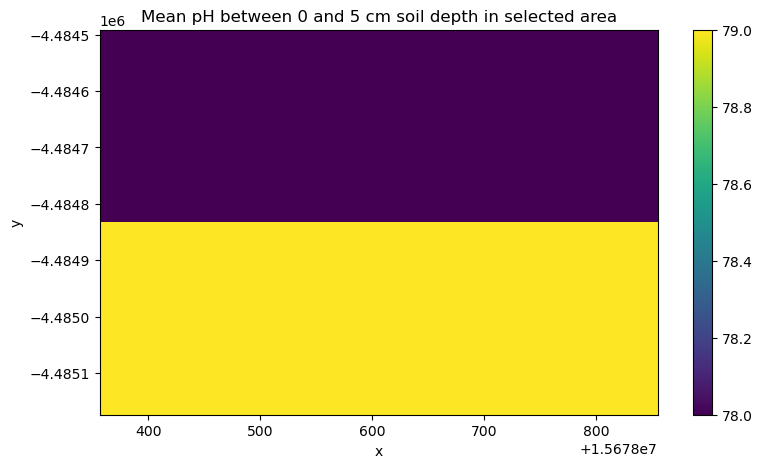

In [16]:
# b) Soil-grids' features: downloading and saving
# ValueError: Please provide a coordinate system code from the following options for crs:
# urn:ogc:def:crs:EPSG::152160
# urn:ogc:def:crs:EPSG::4326
# urn:ogc:def:crs:EPSG::3857
# urn:ogc:def:crs:EPSG::54009
# urn:ogc:def:crs:EPSG::54012
# urn:ogc:def:crs:EPSG::152160
!pip install soilgrids
from soilgrids import SoilGrids

# Reproject the GeoDataFrame to EPSG:3857
fields = fields.to_crs(epsg=3857)

# Get the bounding box of the reprojected polygon
bounds = fields.geometry.bounds
west, south, east, north = min(bounds.minx), min(bounds.miny), max(bounds.maxx), max(bounds.maxy)

# Get data from SoilGrids
soil_grids = SoilGrids()
data = soil_grids.get_coverage_data(service_id='phh2o', coverage_id='phh2o_0-5cm_mean',
                                    west=west-100, south=south-100, east=east+100, north=north+100,
                                    crs='urn:ogc:def:crs:EPSG::3857', output='test1.tif')

# Show metadata
for key, value in soil_grids.metadata.items():
    print('{}: {}'.format(key, value))

# Plot data
data.plot(figsize=(9, 5))
plt.title('Mean pH between 0 and 5 cm soil depth in selected area')
plt.show()

In [17]:
data1 = data.rio.reproject("EPSG:4326")

In [18]:
data1_upsampled.rio.to_raster('Soil_Grids_4326.tif')

NameError: name 'data1_upsampled' is not defined

In [19]:
# Automated rescaling the images to the same resolution using python tools
from rasterio.enums import Resampling

upscale_factor = 10
new_width = data1.rio.width * upscale_factor
new_height = data1.rio.height * upscale_factor

data1_upsampled = data1.rio.reproject(
    data1.rio.crs,
    shape=(new_height, new_width),
    resampling=Resampling.bilinear,
)

data1_upsampled.rio.resolution()

(0.00023395238012540178, -0.00023395238012575704)

In [20]:
clipped = data1_upsampled.rio.clip(fields.geometry.values, fields.crs, drop=False, invert=True)
# Note: If you have rasterio < 1.2 you will need convert the geometries to dict-like objects if the projection
# of the geometries differ from the raster. For example:
#
# from shapely.geometry import mapping
#  geometries = geodf.geometry.apply(mapping)

In [21]:
clipped.rio.to_raster('output2.tif')

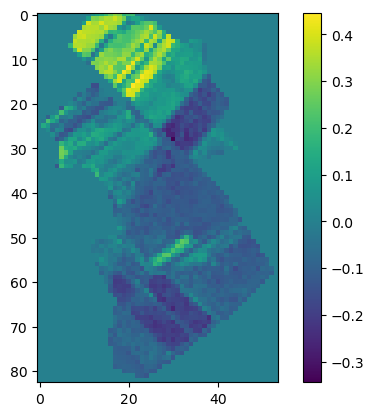

In [22]:
plt.imshow(NDVI)
plt.colorbar()
plt.show()

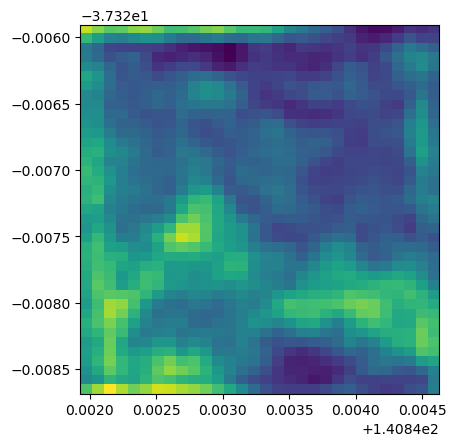

In [23]:
# testing pre-reshaped env datasets
Hayes_432 = rasterio.open(r'C:\Deepplanet\!Tools\ML_Geospatial_Alexey/RGB_Hayes/Hayes_Clip_2024-07-31-00_00_2024-07-31-23_59_Sentinel-2_L2A_False_color.tiff')
B1_Hayes_432_arr = Hayes_432.read(1)
B2_Hayes_432_arr = Hayes_432.read(2)
B3_Hayes_432_arr = Hayes_432.read(3)
S2B4 = B1_Hayes_432_flatten = B1_Hayes_432_arr.reshape(-1, 1)
S2B3 = B2_Hayes_432_flatten = B2_Hayes_432_arr.reshape(-1, 1)
S2B2 = B3_Hayes_432_flatten = B3_Hayes_432_arr.reshape(-1, 1)
rasterio.plot.show(Hayes_432)

Hayes_NDVI = rasterio.open(r'C:\Deepplanet\!Tools\ML_Geospatial_Alexey/RGB_Hayes/Hayes_Clip_NDVI_2024-07-31-00_00_2024-07-31-23_59_Sentinel-2_L2A_False_color.tiff')
Hayes_NDVI_arr = Hayes_NDVI.read()
NDVI_flatten = Hayes_NDVI_flatten = Hayes_NDVI_arr.reshape(-1, 1)

Hayes_SG = rasterio.open(r'C:\Deepplanet\!Tools\ML_Geospatial_Alexey/RGB_Hayes/Hayes_Soil_Grids.tif')
Hayes_SG_arr = Hayes_SG.read() 
SG = Hayes_SG_arr_flatten = Hayes_SG_arr.reshape(-1, 1)


Hayes_DEM = rasterio.open(r'C:\Deepplanet\!Tools\ML_Geospatial_Alexey/RGB_Hayes/Hayes_Clip_2024-12-10-00_00_2024-12-10-23_59_DEM_COPERNICUS_30_DEM_(Raw) (1).tiff')
Hayes_DEM_arr = Hayes_DEM.read()
DEM = Hayes_DEM_arr_flatten = Hayes_DEM_arr.reshape(-1, 1)

In [24]:
S2B2.shape, DEM.shape, S2B4.shape

((1170, 1), (1170, 1), (1170, 1))

In [29]:

#features = gpd.GeoDataFrame({'DEM': DEM.tolist(), 'NDVI': NDVI_flatten.flatten(), 'S2B4': S2B4.flatten(), 'S2B3': S2B3.flatten(), 'S2B2': S2B2.flatten()})
features = gpd.GeoDataFrame({'NDVI': NDVI_flatten.flatten(), 'S2B4': S2B4.flatten(), 'S2B3': S2B3.flatten(), 'S2B2': S2B2.flatten()})

In [30]:
features

,NDVI,S2B4,S2B3,S2B2
0,-0.040,0.716,0.334,0.308
1,-0.042,0.689,0.315,0.290
2,-0.049,0.666,0.303,0.275
3,-0.043,0.669,0.305,0.280
4,-0.032,0.690,0.318,0.298
...,...,...,...,...
1165,-0.052,0.497,0.176,0.159
1166,-0.071,0.500,0.189,0.164
1167,-0.056,0.518,0.197,0.176
1168,-0.040,0.522,0.187,0.173


### IV. cLHS  

In [ ]:
# 1. set CALCULATED or PREDEFINED sample number
# 2. implement using the stacked parameters
# 3. add more important environmental features (find/calculate optimal features)
# 4. define the optimal number of samples 
num_sample=number_samples=10
# cLHS

#sampled=clhs.clhs(features[['DEM', 'S2B4', 'S2B3', 'S2B2']], num_sample, max_iterations=3000, good_mask=mask_true)
sampled=clhs.clhs(features[['DEM', 'S2B4', 'S2B3', 'S2B2']], num_sample, max_iterations=3000, good_mask=mask_true)
#sampled=clhs.clhs(dem_clip_kmeansed_rxr_gdf["Elevations"], num_sample, max_iterations=3000, good_mask=mask_true)
clhs_sample=features.iloc[sampled["sample_indices"]]
#clhs_sample=dem_clip_kmeansed_rxr_gdf.iloc[sampled["sample_indices"]]
# random sample, as a comparison

random_sample=features[~np.isnan(features['DEM'])].sample(num_sample)
#random_sample=dem_clip_kmeansed_rxr_gdf[dem_clip_kmeansed_rxr_gdf['Elevations'] != np.array(-3.4028235e+38).astype(np.float32)].sample(num_sample)

ValueError: Item wrong length 4482 instead of 1170.

In [ ]:
sampled

NameError: name 'sampled' is not defined

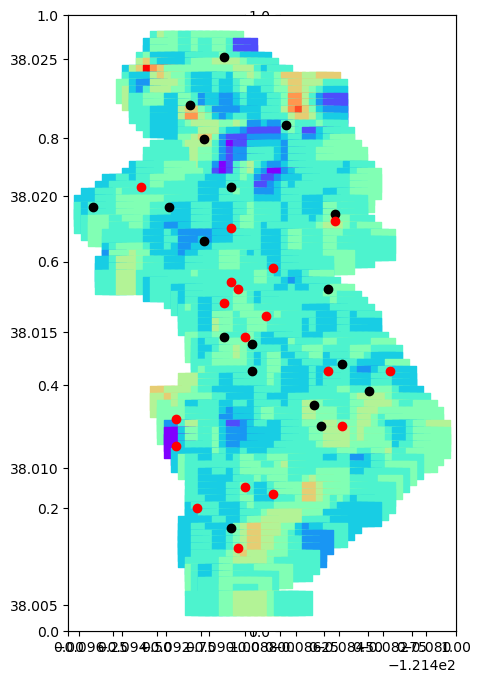

In [ ]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(5, 8))
ax1 = plt.subplot(1,1,1)

ax1.scatter(features.geometry.x, features.geometry.y, c=elevations_true, cmap='rainbow', label='All', marker='s',s=300)
ax1.scatter(clhs_sample.geometry.x, clhs_sample.geometry.y, c='black', label='clhs sampling')
ax1.scatter(random_sample.geometry.x, random_sample.geometry.y, c='red', label='random sampling')

#ax1.scatter(dem_clip_kmeansed_rxr_gdf['x'], dem_clip_kmeansed_rxr_gdf['y'], c=elevations_true, cmap='rainbow', label='All', marker='s',s=300)
#ax1.scatter(clhs_sample['x'], clhs_sample['y'], c='black', label='clhs sampling')
#ax1.scatter(random_sample['x'], random_sample['y'], c='red', label='random sampling')
#ax1.legend()
#ax1.title('Elevations', fontzise=16)

In [ ]:
clhs_sample.to_file(f'cLHS_{number_samples}.geojson')
random_sample.to_file(f'random_{number_samples}.geojson')

C:\Users\rost8\anaconda3\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
C:\Users\rost8\anaconda3\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
